# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
require(doParallel)
registerDoParallel(cores=8)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: compos

### Data pre-processing functions

In [2]:
load_data <- function(file_path) {
    df <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


load_metadata <- function(file_path, df) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% df$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(df, meta) {
    return(df %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(df, frac_presence, read_threshold) {
    n_original <- ncol(df[, colnames(df) != "npm_research_id"])
    PA_df <- apply(df[, 2:ncol(df)], 2, function(x) {ifelse(x > read_threshold, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(df %>% select(all_of(to_keep)))
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(df) {
    mat <- df_filt[, colnames(df_filt) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = df$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_read_samples <- function(df) {
    to_retain <- fread("data/samples_above_10_reads.txt")$npm_research_id
    return(df %>% filter(npm_research_id %in% to_retain))
}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- df[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(df)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}

#### Params

In [3]:
min_samples <- 10
n_subset <- 9999
human <- "Homo sapiens"
rank <- "S"
n <- 9999
frac_presence <- 0
lq_p <- 0.15
hq_p <- 0.85
fold_threshold <- 0
read_threshold <- 10

#### Load and parse data

In [19]:
to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id
df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>% 
    filter(npm_research_id %in% to_retain)
meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df)

# Get metadata subset
meta_filt <- subset_metadata(meta, n)

# Filter data
df_filt <- retrieve_rows_from_meta(df, meta_filt)
df_filt <- remove_cols(df_filt, c(human, "unclassified"))
df_filt <- remove_low_prev_taxa(df_filt, frac_presence = frac_presence, read_threshold = 10)
df_filt <- otu_to_RA(df_filt)
df_filt <- RA_to_clr(df_filt)

# Get metadata columns of interest
meta_cols <- get_meta_cols(meta_filt)

# Get non-contaminants
diff_abn_nc <- read.csv(str_glue("results/decontamination/clr_decontamination/nc.n9999.min_samples10.l{lq_p * 100}h{hq_p * 100}.txt"))$taxa
diff_abn_contam <- read.csv(str_glue("results/decontamination/clr_decontamination/contams.n9999.min_samples10.l{lq_p * 100}h{hq_p * 100}.txt"))$taxa
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V2/noncontam.min_samples100.raw.read_t10.S.n9999.txt")$non_contaminants

nc <- intersect(diff_abn_nc, diff_prev_nc)
length(nc)
length(diff_abn_contam)

2183 / 5199 taxa are present in 0 of samples


[1] 184

[1] 1856

### Correlation filter after Diff. Prev. + Diff. Abn.

In [5]:
corr_decontam <- function(df, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %dopar% {
        morsel <- tibble()
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(df[ ,contaminant_taxon], df[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


parse_corr_results <- function(corr_df, nc, corr_t, prop_t) {
    parsed <- corr_res %>%
    group_by(non_contaminant_taxon) %>%
    mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
    summarise(diff = sum(above_corr) / n_distinct(corr_res$contaminant_taxon))
    
    contaminants <- parsed %>%
        filter(diff > prop_t) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- parsed %>%
        filter(diff <= prop_t) %>%
        distinct(non_contaminant_taxon)
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [6]:
corr_res <- corr_decontam(df_filt, nc, diff_abn_contam)
fwrite(corr_res, str_glue("results/decontamination/correlation_decontamination/corr_results.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv"))
# corr_res <- fread("results/decontamination/correlation_decontamination/corr_results.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.csv")

### Choosing  correlation threshold

#### Case studies

In [7]:
corr_df <- corr_res %>%
    mutate(fill_color = case_when(rho <= 0 ~ "<0",
                     rho > 0 & rho <= 0.1 ~ "0-10",
                     rho > 0.1 & rho <= 0.2 ~ "10-20",
                     rho > 0.2 & rho <= 0.3 ~ "20-30",
                     rho > 0.3 ~  ">30")) %>%
    mutate(fill_color = factor(fill_color, levels = c("<0", "0-10", "10-20", "20-30", ">30")))

Saving 6.67 x 6.67 in image



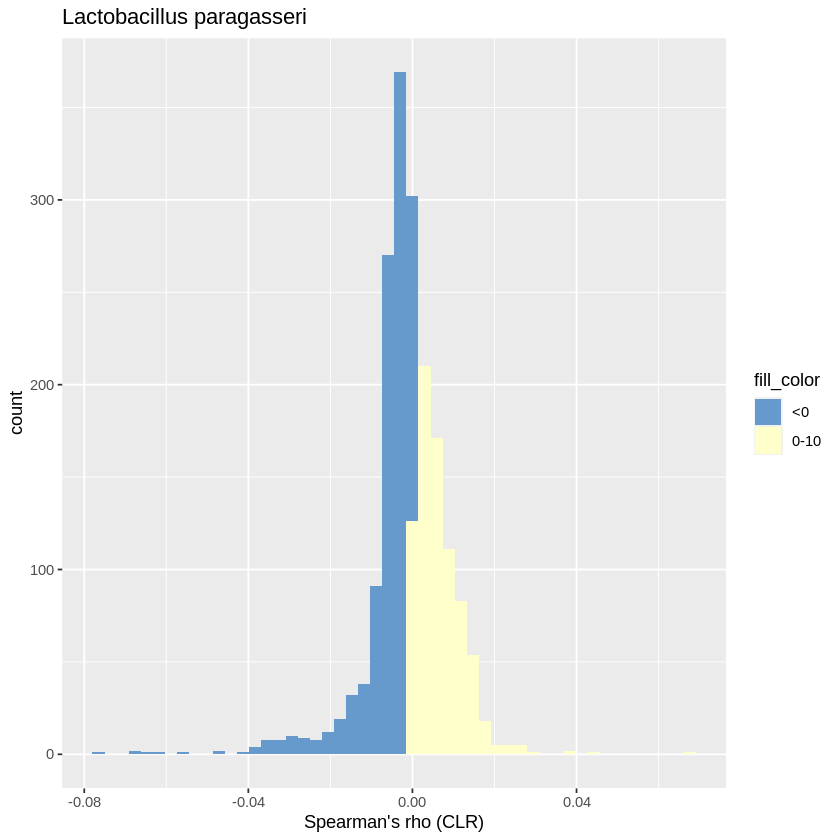

In [23]:
taxon <- "Lactobacillus paragasseri"
taxon_name <- gsub(" ", "_", taxon)

corr_df %>% 
filter(non_contaminant_taxon == taxon) %>%
    ggplot(aes(x = rho, fill = fill_color)) +
    geom_histogram(bins = 50) +
    labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
    scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

Saving 6.67 x 6.67 in image



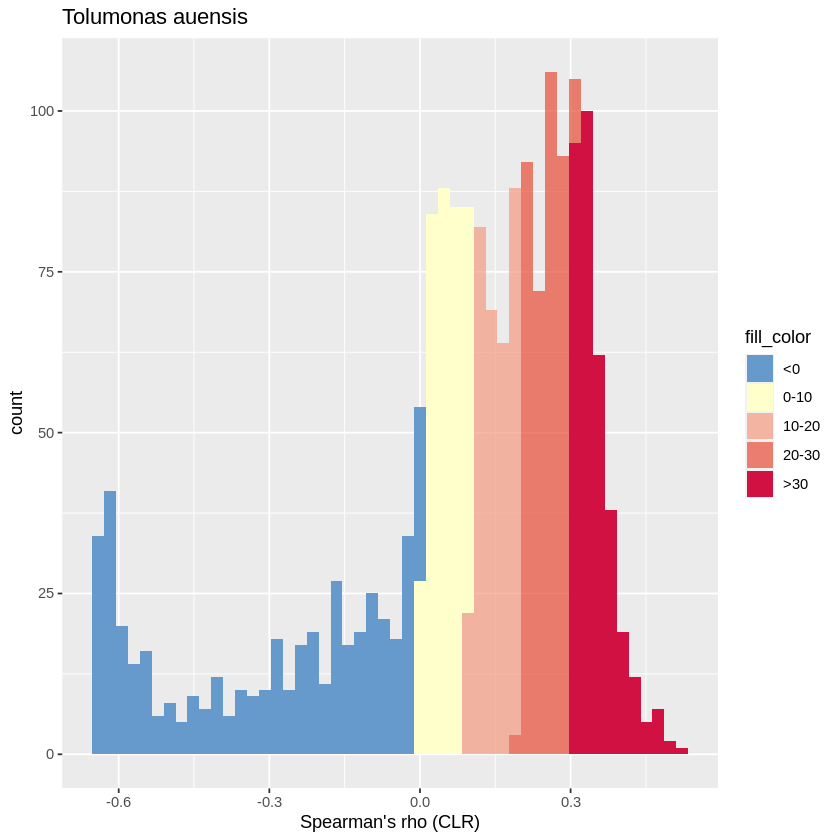

In [22]:
taxon <- "Tolumonas auensis"
taxon_name <- gsub(" ", "_", taxon)
corr_df %>% 
filter(non_contaminant_taxon == taxon) %>%
    ggplot(aes(x = rho, fill = fill_color)) +
    geom_histogram(bins = 50) +
    labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
    scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



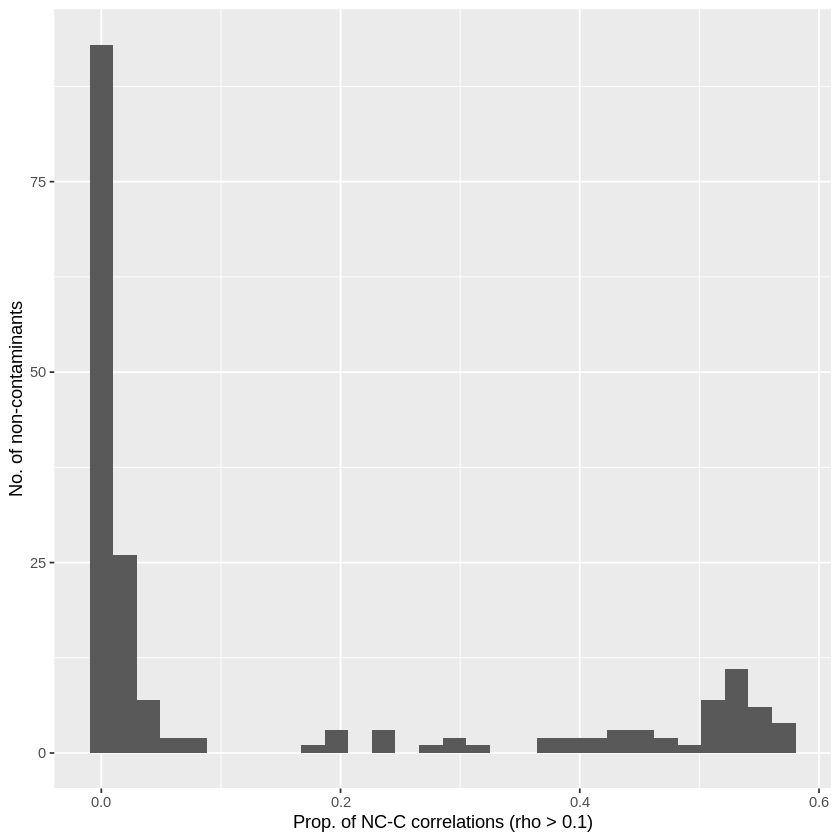

In [10]:
corr_t <- 0.1
parsed <- corr_df %>%
    group_by(non_contaminant_taxon) %>%
    mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
    summarise(diff = sum(above_corr) / n_distinct(corr_df$contaminant_taxon))

parsed %>%
 ggplot(aes(x = diff)) +
    geom_histogram() +
    labs(x = str_glue("Prop. of NC-C correlations (rho > {corr_t})"), y = "No. of non-contaminants")

ggsave(str_glue("results/decontamination/correlation_decontamination/rho_histogram.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

#### Heatmap of correlations

In [13]:
plot_heatmap <- function(corr_df) {
    wide_df <- corr_df %>%
        pivot_wider(!fill_color, names_from = non_contaminant_taxon, values_from = rho) %>%
        column_to_rownames("contaminant_taxon")

    data <- scale(t(wide_df))
    ord_row <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    data <- scale(wide_df)
    ord_col <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    hm <- corr_df %>%
        mutate(non_contaminant_taxon = factor(non_contaminant_taxon, levels = colnames(wide_df)[ord_row]), 
               contaminant_taxon = factor(contaminant_taxon, levels = rownames(wide_df)[ord_col])) %>%
        ggplot(aes(x = non_contaminant_taxon, y = contaminant_taxon, fill = fill_color)) +
        geom_tile() +
        theme(axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank()) +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141")) +
        labs(x = "Non-contaminant species", y = "Contaminant species", fill = "Rho (%)")

    return(hm)
}


#### Before correlation filter

Saving 6.67 x 6.67 in image



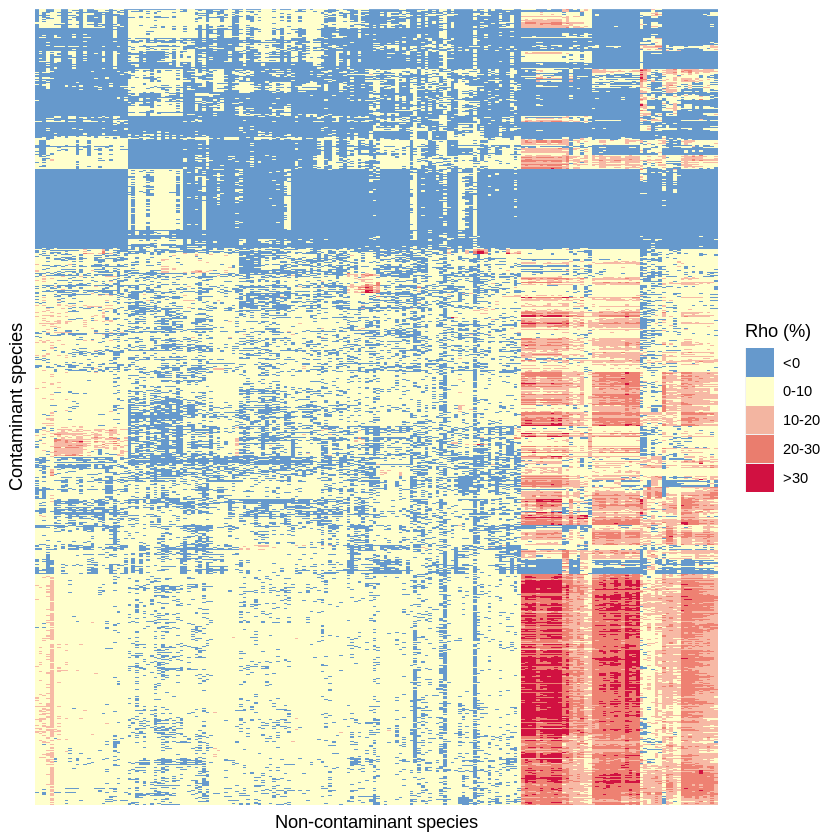

In [14]:
plot_heatmap(corr_df)
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.before_corr.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"), dpi = 300)

In [24]:
corr_parsed <- parse_corr_results(corr_res, nc, corr_t = 0.1, prop_t = 0.1)
corr_nc <- corr_parsed[["non_contaminants"]]
corr_c <- corr_parsed[["contaminants"]]

fwrite(corr_nc, 
       str_glue("results/decontamination/correlation_decontamination/nc.diff_prev.diff_abn.l{lq_p * 100}h{hq_p * 100}.corr_t{corr_t}.S.n9999.txt"))
fwrite(corr_c, 
       str_glue("results/decontamination/correlation_decontamination/contam.diff_prev.diff_abn.l{lq_p * 100}h{hq_p * 100}.corr_t{corr_t}.S.n9999.txt"))

print(length(corr_nc$non_contaminant_taxon))
print(length(corr_c$contaminants))

[1] 130
[1] 54


#### After removal

Saving 6.67 x 6.67 in image



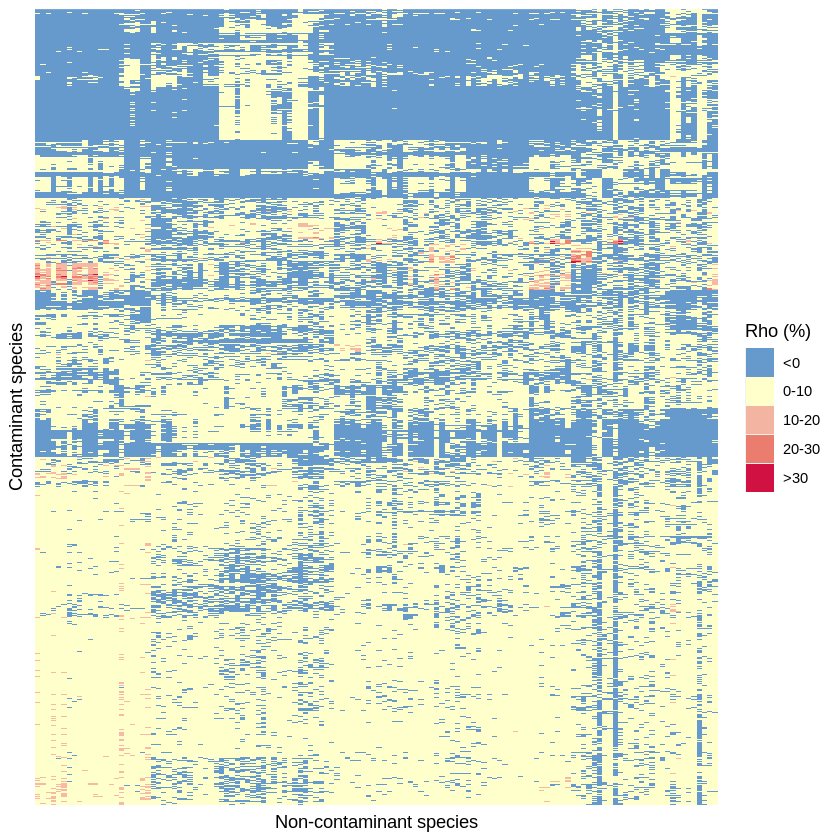

In [17]:
plot_heatmap(corr_df %>% filter(non_contaminant_taxon %in% corr_nc$non_contaminant_taxon))
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.after_corr.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"), dpi = 300)